# Aprendizaje Automático - Tarea 1
## Reconocimiento de letras manuscritas con SVM
#### Nícolas Farfán Cheneaux

In [41]:
import scipy.io
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
from sklearn.svm import SVC 
from scipy.io import loadmat
from collections import defaultdict 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

### Lectura de datos
Dado que el dataset dado está en formato matlab (.mat) se lee mediante la biblioteca scipy

In [42]:
base_path = 'emnist-letters.mat'
data = loadmat(base_path)

Dada la documentación se logra obtener las muestras de imágenes y las etiquetas, indexando el arreglo data y almacenandolo en las variables imgs, labels.
Para un mejor entendimiento se imprime los largos y valores de ejemplo para entender la estructura del dataset.

#### Organización de los datos en diccionarios
Se coloca el total de imágenes por letra(clase) en un diccionario donde la key es cada label, 

Se confirma que cada clase tiene 1000 muestras de entrenamiento y 100 de prueba (distintas entre si dado que se seleciona aleatoriamente 1100 muestas de cada clase)

#### Organización de los datos de entrenamiento y testing
Dado que se tiene un total de 124.800 imágenes y un total de 26 letras, por cada clase se tendrá 4800 muestras.\
Se convierte los labels a numpy array y se cuentan las muestras por clase.

In [43]:
X_train_data = data['dataset']['train'][0, 0]['images'][0, 0]
y_train_data = data['dataset']['train'][0, 0]['labels'][0, 0]

X_test_data = data['dataset']['test'][0, 0]['images'][0, 0]
y_test_data = data['dataset']['test'][0, 0]['labels'][0, 0]

In [44]:
def organize_by_class(X, y):
    # Inicializa un diccionario para mantener los índices por clase
    class_dict = {i: [] for i in range(1, 27)}  # Clases de 1 a 26
    for index, label in enumerate(y.ravel()):  # Asegúrate de que 'y' es un array 1D
        class_dict[label].append(index)
    return class_dict

# Organizar los datos de entrenamiento y prueba por clases
class_indices_train = organize_by_class(X_train_data, y_train_data)
class_indices_test = organize_by_class(X_test_data, y_test_data)

In [45]:
def select_samples(class_dict, num_samples):
    indices = []
    for label, idxs in class_dict.items():
        if len(idxs) < num_samples:
            raise ValueError(f"Clase {label} tiene menos ejemplos ({len(idxs)}) que el número de muestras deseado ({num_samples}).")
        selected_indices = np.random.choice(idxs, num_samples, replace=False)
        indices.extend(selected_indices)
    return indices

# Seleccionar 1000 muestras de entrenamiento y 100 de prueba para cada clase
train_indices = select_samples(class_indices_train, 1000)
test_indices = select_samples(class_indices_test, 100)


In [77]:
# Subconjunto de datos y etiquetas usando los índices aleatorios
X_train = X_train_data[train_indices]
y_train = y_train_data[train_indices].ravel()  # Asegurarse de que y es un arreglo 1D
X_test = X_test_data[test_indices]
y_test = y_test_data[test_indices].ravel()  # Asegurarse de que y es un arreglo 1D

## Experimento n°1
Se normalizan los vectores

In [78]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Entrenamiento del modelo SVM con kernel rbf

In [82]:
svm_model = SVC(kernel = "rbf")
svm_model.fit(X_train, y_train)

SVC()

In [83]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_model, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train[:3500], y_train.ravel()[:3500])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...C=6.300518934339031, gamma=0.0038021979868677292; total time=   2.4s
[CV] END ...C=6.300518934339031, gamma=0.0038021979868677292; total time=   2.3s
[CV] END ...C=6.300518934339031, gamma=0.0038021979868677292; total time=   2.3s
[CV] END ....C=5.382781342365406, gamma=0.011198469181398213; total time=   3.7s
[CV] END ....C=5.382781342365406, gamma=0.011198469181398213; total time=   4.1s
[CV] END ....C=5.382781342365406, gamma=0.011198469181398213; total time=   3.7s
[CV] END ....C=2.72273382257199, gamma=0.0011074830352197256; total time=   1.2s
[CV] END ....C=2.72273382257199, gamma=0.0011074830352197256; total time=   1.4s
[CV] END ....C=2.72273382257199, gamma=0.0011074830352197256; total time=   1.3s
[CV] END ...C=4.989449697222545, gamma=0.0011107693145562913; total time=   1.2s
[CV] END ...C=4.989449697222545, gamma=0.0011107693145562913; total time=   1.2s
[CV] END ...C=4.989449697222545, gamma=0.0011107

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B411945C10>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B4118F83E0>},
                   verbose=2)

In [84]:
rnd_search_cv.best_estimator_

SVC(C=9.357365930430243, gamma=0.001029618789020042)

In [85]:
rnd_search_cv.best_score_

0.945713378632814

In [86]:
svm_model_adjusted = SVC(kernel = "rbf", C = 9.357365930430243, gamma = 0.001029618789020042)
svm_model_adjusted.fit(X_train, y_train)

SVC(C=9.357365930430243, gamma=0.001029618789020042)

#### Accuracy
Función **get_accuracy**, se usa la función predict para obtener las etiquetas predichas por el modelo y usando la matriz de confusión se calcula la precisión de cada categoría

In [87]:
def get_accuracy(X_test, y_test, model):
    # Predicciones del modelo, dado las imágenes de prueba se obtiene los labels
    y_pred = model.predict(X_test)

    # Matriz de confusión (Resultados reales vs predicciones)
    cm = confusion_matrix(y_test, y_pred)

    # Calcular la precisión por categoría
    accuracies = cm.diagonal() / cm.sum(axis=1)
    print(classification_report(y_test, y_pred, zero_division=0))

#### Accuracy por Categoría y Total de modelo con y sin ajuste de hiperparámetros
Se muestra las accuries por categoría de la letra "A"(1) a la "Z"(26). Y además la accuracy total 87%

In [88]:
get_accuracy(X_test, y_test, svm_model)

              precision    recall  f1-score   support

           1       0.77      0.85      0.81       100
           2       0.89      0.91      0.90       100
           3       0.89      0.90      0.90       100
           4       0.88      0.81      0.84       100
           5       0.93      0.85      0.89       100
           6       0.88      0.79      0.83       100
           7       0.72      0.68      0.70       100
           8       0.87      0.78      0.82       100
           9       0.67      0.72      0.69       100
          10       0.89      0.93      0.91       100
          11       0.90      0.89      0.89       100
          12       0.69      0.66      0.68       100
          13       0.91      0.90      0.90       100
          14       0.85      0.85      0.85       100
          15       0.87      0.96      0.91       100
          16       0.86      0.95      0.90       100
          17       0.73      0.76      0.75       100
          18       0.84    

In [89]:
get_accuracy(X_test, y_test, svm_model_adjusted)

              precision    recall  f1-score   support

           1       0.77      0.86      0.82       100
           2       0.93      0.95      0.94       100
           3       0.87      0.92      0.89       100
           4       0.94      0.85      0.89       100
           5       0.91      0.87      0.89       100
           6       0.85      0.82      0.84       100
           7       0.75      0.74      0.74       100
           8       0.93      0.83      0.88       100
           9       0.69      0.71      0.70       100
          10       0.90      0.92      0.91       100
          11       0.89      0.91      0.90       100
          12       0.66      0.67      0.66       100
          13       0.89      0.92      0.91       100
          14       0.92      0.84      0.88       100
          15       0.91      0.98      0.94       100
          16       0.88      0.96      0.92       100
          17       0.77      0.72      0.74       100
          18       0.84    

#### Visualización de un ejemplo con la letra real vs la predicción

In [56]:
def visualize_prediction(X, y, model, index):
    image = X[index].reshape(28, 28)  # Redimensionar el vector a 28x28 para visualización
    image = np.rot90(image, k=-1)
    image = np.fliplr(image)
    true_label_index = y[index]  # Índice de la etiqueta verdadera
    predicted_label_index = model.predict([X[index]])[0] 
    
    true_label = chr(true_label_index + 64)  # 64 + 1 = 65, que es 'A' en Unicode
    predicted_label = chr(predicted_label_index + 64)  # 64 + 'índice' para obtener la letra correcta
    
    # Mostrar la imagen
    plt.imshow(image, cmap='gray')
    plt.title(f'Index: {index}\nTrue Label: {true_label}\nPredicted Label: {predicted_label}')
    plt.colorbar()
    plt.grid(False)
    plt.show()

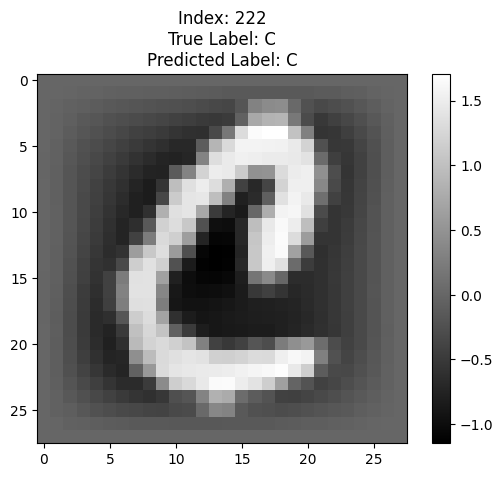

In [57]:
visualize_prediction(X_test, y_test, svm_model, 222)

## Experimento n°2
Se utiliza PCA para reducir de 784 a 128 la dimensión de los vectores.

In [90]:
# Inicializar PCA con 128 componentes
pca = PCA(n_components = 128)

# Entrena PCA
pca.fit(X_train)

# Ajustar y transformar los datos
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape

(26000, 128)

Entrenamiento del modelo con los datos reducidos por PCA

In [91]:
svm_model_pca = SVC(kernel='rbf')
svm_model_pca.fit(X_train_pca, y_train)

SVC()

#### Accuracy por Categoría y Total

In [92]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_pca = RandomizedSearchCV(svm_model_pca, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_pca.fit(X_train_pca[:3500], y_train.ravel()[:3500])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=9.593409474005007, gamma=0.004646228193086938; total time=   0.5s
[CV] END ....C=9.593409474005007, gamma=0.004646228193086938; total time=   0.5s
[CV] END ....C=9.593409474005007, gamma=0.004646228193086938; total time=   0.5s
[CV] END .....C=7.06314647947614, gamma=0.004157162830130484; total time=   0.5s
[CV] END .....C=7.06314647947614, gamma=0.004157162830130484; total time=   0.5s
[CV] END .....C=7.06314647947614, gamma=0.004157162830130484; total time=   0.5s
[CV] END ...C=2.4254956523831352, gamma=0.056862375824384914; total time=   0.9s
[CV] END ...C=2.4254956523831352, gamma=0.056862375824384914; total time=   0.9s
[CV] END ...C=2.4254956523831352, gamma=0.056862375824384914; total time=   0.9s
[CV] END ....C=6.801719455631144, gamma=0.012604102266671541; total time=   0.8s
[CV] END ....C=6.801719455631144, gamma=0.012604102266671541; total time=   0.8s
[CV] END ....C=6.801719455631144, gamma=0.012604

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B4118D7A10>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B414336B40>},
                   verbose=2)

In [93]:
best_svmpca_model = rnd_search_pca.best_estimator_
best_svmpca_model

SVC(C=6.966685478321949, gamma=0.0014151628625696535)

In [94]:
rnd_search_cv.best_score_

0.945713378632814

In [95]:
svm_modelpca_adjusted = SVC(kernel = "rbf", C = 6.966685478321949, gamma=0.0014151628625696535)
svm_modelpca_adjusted.fit(X_train_pca, y_train)

SVC(C=6.966685478321949, gamma=0.0014151628625696535)

In [63]:
get_accuracy(X_test_pca, y_test, svm_model_pca)

              precision    recall  f1-score   support

           1       0.79      0.85      0.82       100
           2       0.93      0.94      0.94       100
           3       0.90      0.91      0.91       100
           4       0.90      0.83      0.86       100
           5       0.95      0.87      0.91       100
           6       0.89      0.81      0.85       100
           7       0.76      0.73      0.74       100
           8       0.87      0.81      0.84       100
           9       0.68      0.70      0.69       100
          10       0.91      0.94      0.93       100
          11       0.89      0.90      0.90       100
          12       0.68      0.68      0.68       100
          13       0.91      0.92      0.92       100
          14       0.89      0.86      0.87       100
          15       0.88      0.98      0.92       100
          16       0.85      0.94      0.90       100
          17       0.75      0.77      0.76       100
          18       0.86    

In [64]:
get_accuracy(X_test_pca, y_test, svm_modelpca_adjusted)

              precision    recall  f1-score   support

           1       0.81      0.88      0.85       100
           2       0.90      0.95      0.93       100
           3       0.90      0.92      0.91       100
           4       0.95      0.89      0.92       100
           5       0.91      0.91      0.91       100
           6       0.93      0.85      0.89       100
           7       0.75      0.72      0.73       100
           8       0.90      0.85      0.88       100
           9       0.68      0.73      0.71       100
          10       0.93      0.94      0.94       100
          11       0.88      0.92      0.90       100
          12       0.69      0.66      0.67       100
          13       0.92      0.92      0.92       100
          14       0.91      0.88      0.89       100
          15       0.90      0.98      0.94       100
          16       0.92      0.97      0.94       100
          17       0.78      0.73      0.76       100
          18       0.86    

## Experimento n°3
Vectores de características entrenados extraídos de una red convolucional simple entrenada en EMNIST

In [65]:
# Dataframe de entrenamiento
df_train = pd.read_csv('train_embeddings.csv')
df_train = df_train.sample(n=1000, random_state=42)

# Dataframe de prueba
df_test = pd.read_csv('test_embeddings.csv')
df_test = df_test.sample(n=100, random_state=42)

In [66]:
X_train = df_train.drop('label', axis=1).values
y_train = df_train['label'].values

# Se divide la data en características y labels
X_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

Entrenamiento del modelo con los vectores de característica dados

In [67]:
svm_vec = SVC(kernel = "rbf")
svm_vec.fit(X_train, y_train)

SVC()

#### Accuracy por Categoría y Total

In [68]:
get_accuracy(X_test, y_test, svm_vec)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       1.00      0.80      0.89         5
           5       1.00      0.50      0.67         2
           6       0.67      0.67      0.67         3
           7       1.00      1.00      1.00         3
           8       0.57      1.00      0.73         4
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         5
          11       1.00      0.60      0.75         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       0.86      1.00      0.92         6
          16       0.86      0.86      0.86         7
          17       1.00    

C:\Users\n1c8l\AppData\Local\Temp\ipykernel_18064\1174503523.py:9: RuntimeWarning: invalid value encountered in divide
  accuracies = cm.diagonal() / cm.sum(axis=1)
